# Датасет по данным чятика

### Немного упоролся и решил поизучать чего понапописал народ в чатике по алгоритмам

Чтобы вытащить данные буду использовать библиотеку **telethon**

Для начала авторизуемся

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from telethon import TelegramClient

import pandas as pd
import numpy as np

from collections import Counter
from time import time

api_id = XXX
api_hash = 'XXX'
phone_number = '+XXX'

client = TelegramClient('session_id', api_id=api_id, api_hash=api_hash)

# client.start()
assert client.connect()

if not client.is_user_authorized():
    client.send_code_request(phone_number)
    me = client.sign_in(phone_number, input('Enter code: '))
    print(me.stringify())
    
chat_id = -1001086446998

Немного туповатый код, так как я для начала оценивал скорость скачивания сообщений. Оказалось порядка 20 сообщений в секунду. Негусто так то, учитывая, что бывают чатики, которые временами генерят контент с такой скоростью) Но нам хватит

In [2]:
from time import time
# last_messages_list = [10, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 100000]
last_messages_list = [1000000]
load_duration_dict = {}
for mess_count in last_messages_list:
    t_start = time()
    messages = client.get_message_history(chat_id, limit=mess_count)
    load_duration_dict[mess_count] = int(time() - t_start)
    print('{0} messages loads about {1} seconds'.format(len(messages), load_duration_dict[mess_count]))
    print('Last message is \'{}\''.format(messages[-1].message))
    print('date: ', messages[-1].date)
    print('=================================')

262884 messages loads about 4277 seconds
Last message is 'None'
date:  2016-10-06 14:06:45


In [13]:
messages[-1].message

'теперь можно пинить сообщения )'

### Вот так я могу обновлять свои данные, просто догружая все сообщения после последнего сохраненного

In [253]:
last_messages = client.get_message_history(chat_id, min_id=messages[0].id, limit=100500)
for mes in last_messages:
    print(mes.message)

я имею ввиду изучать оба на уровне хотя бы graduate level engineer
и то и то - это хобби)
Если я правильно понял :)
Одно другому никак не мешает ведь
есть олимпиадники асм или software engineers которые паралельно занимаются мл/дс? хотел проконсультироваться по сложности обучения в двух направлениях


### Немного почистил данные от вспомогательных сообщений, которые усложняют процессинг

In [3]:
import re

entry_messages = []
work_messages = []
# old_messages = messages
for mes in messages:
    try:
        mes.media
        work_messages.append(mes)
    except:
        entry_messages.append(mes)
messages = work_messages

### Чуть посмотрел на эти самые вспомогательные сообщения, посчитал кто как часто их генерит

In [4]:
from collections import Counter
users = []
users_ids = []
for mes in entry_messages:
    username = mes.sender.username
    users_ids.append(mes.from_id)
    if username:
        users.append(username)
    else:
        users.append(str(mes.sender.last_name) + '/' + str(mes.sender.first_name))
    
print(len(Counter(users).most_common()))
Counter(users).most_common(10)

253


[('Aliskin', 65),
 ('veryany', 13),
 ('None/None', 11),
 ('oayunin', 6),
 ('Sergey_Divakov', 6),
 ('vitekmel', 5),
 ('vlad8', 5),
 ('mikari', 4),
 ('deamoon', 4),
 ('siri3us', 3)]

### Построил собственно датасет из самого необходимого

Также удалил всякую пунктуацию и построил себе айдишку пользователя из имени, фамилии, логина

In [5]:
corpus = pd.DataFrame(data = {
    'text': [mes.message for mes in messages],
    'is_media': [not mes.media == None for mes in messages],
    'is_bot': [mes.sender.bot for mes in messages],
    'writer_id': [mes.from_id for mes in messages],
    'username': [mes.sender.username for mes in messages],
    'first_name': [mes.sender.first_name for mes in messages],
    'last_name': [mes.sender.last_name for mes in messages],
    'mes_date': [mes.date for mes in messages],
    
})
corpus = corpus[~corpus.is_bot]
corpus = corpus[['mes_date', 'text', 'is_media', 'username', 'writer_id', 'first_name', 'last_name']]
corpus.text = corpus.text.fillna('').astype(str)

def remove_links_and_quotes(text):
    return ' '.join([word for word in text.split() if 'http' not in word and '@' not in word])
corpus.text = corpus.text.apply(lambda x: remove_links_and_quotes(x))

corpus = corpus[corpus.text.apply(lambda x: len(x) > 0)]
corpus.text = corpus.text.apply(lambda x: ' '.join(re.split('\W+', x.lower())))
corpus.sort_values('mes_date', inplace=True, ascending=True)

corpus.fillna('', inplace=True)
corpus['chatname'] = corpus['last_name'] + '_' + corpus['first_name'] + '(' + corpus['username'] + ')'

corpus.to_csv('algo_chat.csv', index=None)

corpus.head(10)

,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
262484,2016-10-06 14:10:16,теперь можно пинить сообщения,False,Aliskin,135646107,Alisa,Smirnova,Smirnova_Alisa(Aliskin)
262483,2016-10-06 14:10:51,про опубликают проверят непонятно важность ког...,False,Aliskin,135646107,Alisa,Smirnova,Smirnova_Alisa(Aliskin)
262482,2016-10-06 14:11:25,информация уже начала отличаться кто то говори...,False,defective_bliss,275127543,Defective,Bliss,Bliss_Defective(defective_bliss)
262481,2016-10-06 14:11:38,что за фигня с энитаском контестом,False,AlexErofeev,32739025,Fram,,_Fram(AlexErofeev)
262480,2016-10-06 14:11:48,а как пинить,False,shuternay,69745500,Sergey,Kiselev,Kiselev_Sergey(shuternay)
262479,2016-10-06 14:11:53,есть же поиск по чатику,False,,149148217,Natasha,Kharchenko,Kharchenko_Natasha()
262478,2016-10-06 14:11:57,не паниковать а проявлять недовольство,False,AlexErofeev,32739025,Fram,,_Fram(AlexErofeev)
262477,2016-10-06 14:11:58,а все равно раньше чем проверят не проверят ка...,False,crassirostris,46327441,Mikhail,Vyatskov,Vyatskov_Mikhail(crassirostris)
262476,2016-10-06 14:12:04,,False,AlexErofeev,32739025,Fram,,_Fram(AlexErofeev)
262475,2016-10-06 14:12:26,ещё можно себе в личку переслать тогда уж,False,shuternay,69745500,Sergey,Kiselev,Kiselev_Sergey(shuternay)


In [48]:
corpus = pd.read_csv('algo_chat.csv')
corpus.fillna('', inplace=True)
corpus.mes_date = pd.to_datetime(corpus.mes_date)
corpus.head()

,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
0,2017-10-08 11:39:58,ануар можно мне сразу админство плс,False,,172015031,Yeldos,Balgabekov,Balgabekov_Yeldos()
1,2017-10-08 11:45:25,крч всем привет создал конфу в телеграмме для ...,False,cSneddy,212657982,Пельмешка,Sneddy,Sneddy_Пельмешка(cSneddy)
2,2017-10-08 12:17:14,запинь,False,hoogleraar,108539635,Дархан,,_Дархан(hoogleraar)
3,2017-10-08 12:52:51,всем привет,False,,50045174,Renat,Alimbekov,Alimbekov_Renat()
4,2017-10-08 13:01:34,,True,adilkhash,151436083,Adil,,_Adil(adilkhash)


In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

def tokenize_me(file_text):
    #firstly let's apply nltk tokenization
    tokens = nltk.word_tokenize(file_text)

    #deleting stop_words
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    stop_words.extend(stopwords.words('english'))
    tokens = [i for i in tokens if ( i not in stop_words )]
    
    #cleaning words
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]

    return ' '.join(tokens)

corpus.text = corpus.text.apply(lambda x: tokenize_me(x))

corpus.to_csv('algo_chat_tokens.csv', index=None)
corpus.head(10)

[nltk_data] Downloading package punkt to /home/sneddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sneddy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
262484,2016-10-06 14:10:16,пинить сообщения,False,Aliskin,135646107,Alisa,Smirnova,Smirnova_Alisa(Aliskin)
262483,2016-10-06 14:10:51,опубликают проверят непонятно важность опублик...,False,Aliskin,135646107,Alisa,Smirnova,Smirnova_Alisa(Aliskin)
262482,2016-10-06 14:11:25,информация начала отличаться говорил 3 дня мак...,False,defective_bliss,275127543,Defective,Bliss,Bliss_Defective(defective_bliss)
262481,2016-10-06 14:11:38,фигня энитаском контестом,False,AlexErofeev,32739025,Fram,,_Fram(AlexErofeev)
262480,2016-10-06 14:11:48,пинить,False,shuternay,69745500,Sergey,Kiselev,Kiselev_Sergey(shuternay)
262479,2016-10-06 14:11:53,поиск чатику,False,,149148217,Natasha,Kharchenko,Kharchenko_Natasha()
262478,2016-10-06 14:11:57,паниковать проявлять недовольство,False,AlexErofeev,32739025,Fram,,_Fram(AlexErofeev)
262477,2016-10-06 14:11:58,равно раньше проверят проверят разница,False,crassirostris,46327441,Mikhail,Vyatskov,Vyatskov_Mikhail(crassirostris)
262476,2016-10-06 14:12:04,,False,AlexErofeev,32739025,Fram,,_Fram(AlexErofeev)
262475,2016-10-06 14:12:26,ещё личку переслать,False,shuternay,69745500,Sergey,Kiselev,Kiselev_Sergey(shuternay)


### Посмотрим, кто понапописал больше всех сообщений и наоставлял всяких стикеров

In [8]:
corpus.groupby('chatname')['text'].count().sort_values(ascending=False).head(20)

chatname
Khairullin_Egor(mikari)             28838
Baskov_Ivan(Dest31337)              20958
Smirnova_Alisa(Aliskin)             20914
_Dmitriy(veryany)                   15330
Bliss_Defective(defective_bliss)    13785
Vyatskov_Mikhail(crassirostris)     13561
Mikhailov_Aleksandr(sashamn)        11851
Britkov_Radomir(Radi4)              10797
Kiselev_Sergey(shuternay)           10387
Se_Lio(asemchankau)                  9904
Omelyanenko_Victor(vitekmel)         9231
_Fram(AlexErofeev)                   8801
Мац_Владислав(vlad8)                 6265
Mazaev_Pavel(itasarom)               5408
Gorishniy_Yura(StrausMG)             4277
Olokhtonov_Vladimir(sgjurano)        4245
_kochka(zagop)                       4215
_Ivan(egorich239)                    4036
_Svetlana Pervykh(firstsvet)         3373
Tiunov_Alexander(astiunov)           3268
Name: text, dtype: int64

In [9]:
corpus.groupby('chatname')['is_media'].sum().sort_values(ascending=False).astype(int).head(20)

chatname
_Dmitriy(veryany)                   132
_Ivan(egorich239)                   126
Mikhailov_Aleksandr(sashamn)         99
_Fram(AlexErofeev)                   95
Smirnova_Alisa(Aliskin)              77
Se_Lio(asemchankau)                  57
Bliss_Defective(defective_bliss)     49
Vyatskov_Mikhail(crassirostris)      39
Kiselev_Sergey(shuternay)            39
Evseev_Mikhail()                     37
Omelyanenko_Victor(vitekmel)         35
_Svetlana Pervykh(firstsvet)         33
Olokhtonov_Vladimir(sgjurano)        32
Kharitonov_Valery(kharvd)            31
Брагин_Сергей(arbel0s)               27
Khairullin_Egor(mikari)              27
_Mike(electrosnake)                  26
_That Guy(Erring)                    24
Gorishniy_Yura(StrausMG)             19
Baskov_Ivan(Dest31337)               17
Name: is_media, dtype: int64

### Оценим число мало активных ребятишек
Cначала посчитаем тех, кто хоть что-то написал

In [14]:
corpus.writer_id.unique().shape

(292,)

In [15]:
(corpus.groupby('chatname')['text'].count() > 10).sum()

178

### Посмотрим на активность чатика по дням

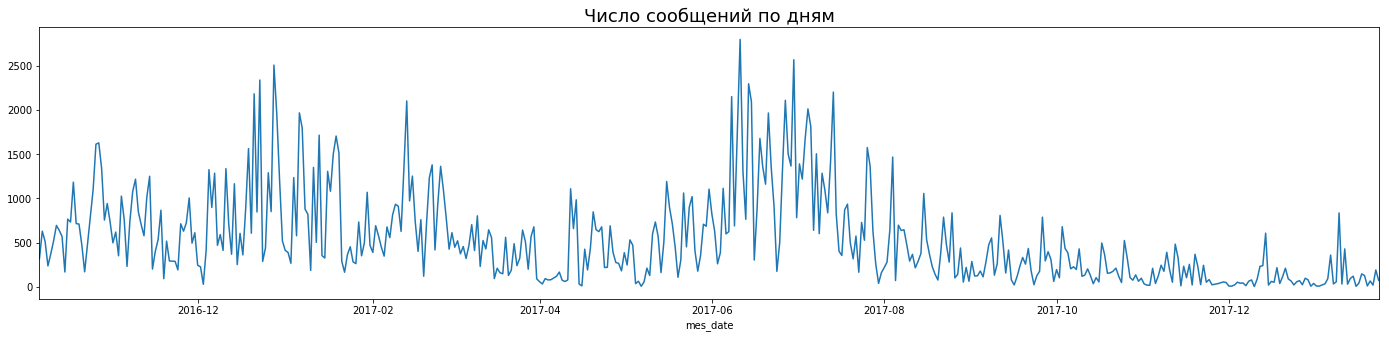

In [19]:
import matplotlib.pylab as plt
%matplotlib inline

corpus.groupby(corpus.mes_date.dt.date).count().mes_date.plot(figsize=(24,5))
plt.title('Число сообщений по дням', fontsize=18)
plt.savefig('by date.png', fps=400)

### И по времени: как видим максимум неплохо коррелирует с рабочим днем:)

Пришел на работу - открыл чатик. Все правильно сделал!

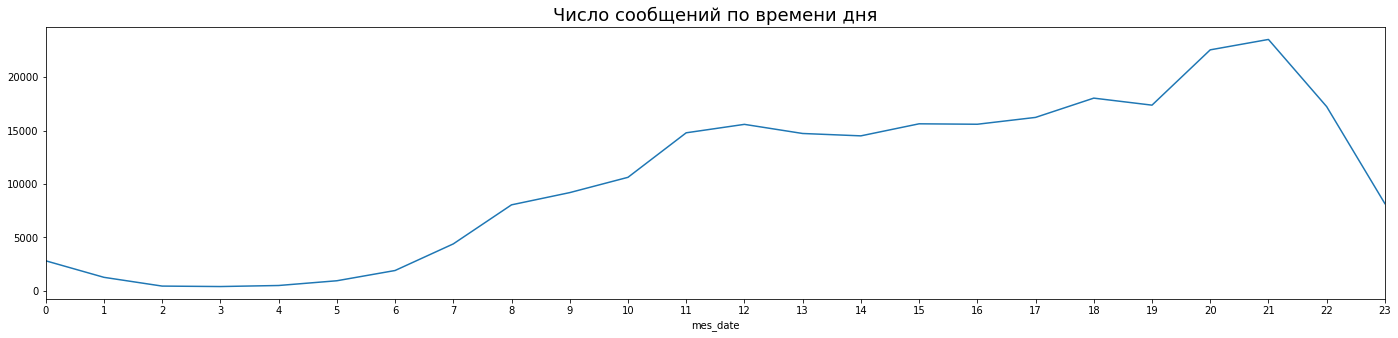

In [21]:
import matplotlib.pylab as plt
%matplotlib inline

corpus.groupby(corpus.mes_date.dt.hour).count().mes_date.plot(figsize=(24,5))
plt.title('Число сообщений по времени дня', fontsize=18)
plt.xticks(range(24))
plt.savefig('by hours.png', fps=400)
plt.show()

# Тематическая модель по пользователям

### Фильтрация по частям речи

In [108]:
import pymorphy2

users_text = corpus[corpus.chatname.map((corpus.groupby('chatname')['text'].count() > 50))]

users_text = users_text.groupby('chatname').agg(lambda x: ' '.join(x))['text']

morph = pymorphy2.MorphAnalyzer()

In [331]:
# Apro
def normalise_string(input_str):
    bad_words = {'че','чет','её','ещё','такой','который','какой','очень',}
    norm_words_list = []
    for word in input_str.split():
        if not word.isdigit() and word not in bad_words:
            parsed = morph.parse(word)[0]
            if parsed.tag.POS not in {'NUMR', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}:
                norm_words_list.append(parsed.normal_form)
    return ' '.join(norm_words_list)

%time users_text_norm = users_text.apply(lambda x: normalise_string(x))
users_text_norm.head()

CPU times: user 2min 51s, sys: 44 ms, total: 2min 51s
Wall time: 2min 51s


chatname
*_void(MarinaRiemann)            происходить о_о сам заплатить нравиться ребята...
A_Stefan(astefan1)               жжение ада ада энитаска элемент название задан...
Alexandrov_Nikita(thinkwell)     страсть жарко переключаться почему просить сня...
Averina_Lyubov()                 styleguide план кмк возможный мочь вести обсто...
Bakhmetyeva_Marina(Maaarishk)    styleguide контест вообще папа бежать марафон ...
Name: text, dtype: object

In [332]:
def filter_string(input_str):
    bad_words = {'че','чет','её','ещё','такой','который','какой','очень',}
    norm_words_list = []
    for word in input_str.split():
        if not word.isdigit() and word not in bad_words:
            parsed = morph.parse(word)[0]
            if parsed.tag.POS not in {'NUMR', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}:
                norm_words_list.append(word)
    return ' '.join(norm_words_list)

%time users_text_filter = users_text.apply(lambda x: filter_string(x))
users_text_filter.head()

CPU times: user 2min 36s, sys: 4 ms, total: 2min 36s
Wall time: 2min 36s


chatname
*_void(MarinaRiemann)            происходит о_о сама заплачу нравишься ребят пр...
A_Stefan(astefan1)               жжение ад ад энитаске элемент названиями задан...
Alexandrov_Nikita(thinkwell)     страсти жарко переключайтесь почему просит сня...
Averina_Lyubov()                 styleguide план кмк возможен могут вести обсто...
Bakhmetyeva_Marina(Maaarishk)    styleguide контесте вообще папа бежит марафон ...
Name: text, dtype: object

### Выбор пороговых значений векторизации

Чтобы как-то выкинуть совсем уж редкие слова(аля очепятки) и совсем общеупортребительные слова

In [578]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time

def get_words_by_threshold_report(text_series, min_df=0.02, max_df=0.75):
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)

    counts = vectorizer.fit_transform(text_series)
    corpus_id2word = {value: key for key, value in vectorizer.vocabulary_.items()}

    print('Слов в словаре: {}\n'.format(counts.shape[1]))
    print('Слова до пороговой фильтрации: ', Counter(' '.join(text_series.values).split()).most_common(20), '\n')

    print('Слова у верхней границы:', [corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[-40:][::-1]])
    print()
    print('Слова у нижней границы: ', [corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[:20]])
    return counts, vectorizer, corpus_id2word

def get_lda_model(counts, corpus_id2word, num_topics=10, alpha_value=0.1, var_iter=50, passes=50):
    gensim_corpus = gensim.matutils.Scipy2Corpus(counts)
    t_start = time.time()
    lda = gensim.models.LdaModel(
        corpus=gensim_corpus,
        passes=passes,
        num_topics=num_topics,
        alpha=[alpha_value] * num_topics,
        iterations=var_iter,
        id2word=corpus_id2word,
        eval_every=0,
        random_state=42
    )
    current_score = lda.bound(gensim_corpus)
    score_dict[alpha_value] = current_score
    time_ellapsed = int(time.time() - t_start)

    print('ELBO = {1:.4f}, time: {2} seconds'.format(
        alpha_value, current_score, time_ellapsed))
    
    gamma, _ = lda.inference(gensim_corpus)
    gamma = gamma / gamma.sum(1).reshape(-1, 1)
    
    return lda, gamma

def build_topic_words_report(lda, top_words_num=25, topic_names=None):
    if topic_names==None:
        topic_names = [''] * lda.num_topics
    topic_space = max(map(len, topic_names)) + 2
    
    if topic_space==2:
        for topic_index in range(lda.num_topics):
            print('{0} topic: {1}'.format(
                topic_index, ', '.join(list(zip(*lda.show_topic(topic_index, topn=top_words_num)))[0])))
        return
    
    for topic_index in range(lda.num_topics):
        print('{0} topic :{1: ^{2}}: {3}'.format(
            topic_index, topic_names[topic_index], topic_space,
            ', '.join(list(zip(*lda.show_topic(topic_index, topn=top_words_num)))[0])))
        
def build_topic_subjects_report(lda, gamma, text_series, topic_names=None):
    if topic_names==None:
        topic_names = [''] * lda.num_topics
    for topic_index in range(lda.num_topics):
        print('Topic {0} - {1}'.format(topic_index, topic_names[topic_index]))
        best_doc_indexes = gamma[:, topic_index].argsort()[-10:][::-1]
        
        subjects_with_proba = []
        for person_count, doc in enumerate(best_doc_indexes):
            if gamma[doc, topic_index] > 0.01 or person_count<3:
                subjects_with_proba.append('{0} - {1:.1%}'.format(text_series.index[doc], gamma[doc, topic_index]))
        print(', '.join(subjects_with_proba), '\n')


### Слова в начальной форме

In [346]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_norm, min_df=0.05, max_df=0.85)

Слов в словаре: 11118

Слова до пороговой фильтрации:  [('человек', 6215), ('такой', 5999), ('весь', 5399), ('вообще', 5141), ('один', 4768), ('который', 4417), ('какой', 4048), ('мочь', 4016), ('знать', 3830), ('делать', 3815), ('год', 3759), ('говорить', 3495), ('писать', 3421), ('почему', 3317), ('самый', 3210), ('думать', 3146), ('хотеть', 3100), ('тип', 2973), ('работать', 2952), ('быть', 2924)] 

Слова у верхней границы: ['человек', 'год', 'говорить', 'писать', 'почему', 'самый', 'хотеть', 'тип', 'быть', 'сказать', 'свой', 'тот', 'сделать', 'другой', 'дело', 'проблема', 'курс', 'понимать', 'хороший', 'должный', 'смотреть', 'давать', 'мой', 'чатик', 'нужный', 'код', 'видеть', 'считать', 'читать', 'иметь', 'дать', 'пока', 'каждый', 'норма', 'яндекс', 'алгоритм', 'смысл', 'нормальный', 'твой', 'работа']

Слова у нижней границы:  ['потрясение', 'намутить', 'entity', 'артикль', 'тщательный', 'эра', 'эрудиция', 'en', 'практиковаться', 'выстраивать', 'education', 'блондинка', 'накрутка'

In [351]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_norm, min_df=0.05, max_df=0.75)

Слов в словаре: 11076

Слова до пороговой фильтрации:  [('человек', 6215), ('такой', 5999), ('весь', 5399), ('вообще', 5141), ('один', 4768), ('который', 4417), ('какой', 4048), ('мочь', 4016), ('знать', 3830), ('делать', 3815), ('год', 3759), ('говорить', 3495), ('писать', 3421), ('почему', 3317), ('самый', 3210), ('думать', 3146), ('хотеть', 3100), ('тип', 2973), ('работать', 2952), ('быть', 2924)] 

Слова у верхней границы: ['хороший', 'смотреть', 'чатик', 'считать', 'читать', 'норма', 'яндекс', 'смысл', 'твой', 'работа', 'идти', 'слово', 'стать', 'случай', 'том', 'найти', 'жизнь', 'простой', 'разный', 'деньга', 'россия', 'посмотреть', 'наверное', 'функция', 'жить', 'место', 'большой', 'друг', 'взять', 'ревить', 'ребёнок', 'маленький', 'общий', 'начать', 'решить', 'всякий', 'помнить', 'понятно', 'вид', 'стоить']

Слова у нижней границы:  ['капитальный', 'тиран', 'шарм', 'приземлить', 'голуба', 'практиковаться', 'заграница', 'откатиться', 'гривна', 'имо', 'импичмент', 'истерика', 'тщ

In [352]:
lda_norm, gamma_norm = get_lda_model(counts, corpus_id2word)

ELBO = -5542628.2084, time: 75 seconds


In [353]:
build_topic_words_report(lda_norm, top_words_num=25)

0 topic: хороший, том, функция, далее, случай, хз, идти, разный, смотреть, всякий, куча, std, простой, уметь, работа, питон, сильно, большой, взять, твой, обычно, деньга, язык, брать, читать
1 topic: чатик, девушка, смотреть, слово, ладный, кейтен, читать, считать, жизнь, хороший, яндекс, нравиться, смысл, друг, общий, ребёнок, помнить, разный, стать, твой, алиса, найти, математика, js, поэтому
2 topic: файл, попытка, текст, запустить, норма, язык, сразу, ответ, ревить, остальной, пример, ошибка, странный, ребята, крутой, точка, русский, спросить, ладный, условие, повод, согласный, быстро, минута, о_о
3 topic: чатик, читать, найти, конец, хз, жизнь, начать, ребёнок, вполне, теория, вид, ходить, ссылка, навальный, сообщение, подумать, знакомый, высокий, откуда, качество, говно, смотреть, простой, считать, плохой
4 topic: россия, считать, хороший, страна, естественно, всякий, довольно, вброса, вид, вполне, жить, ссср, сша, го, навальный, случай, насколько, деньга, китай, читать, разный, 

In [354]:
build_topic_subjects_report(lda_norm, gamma_norm)

Topic 0 - 
Khairullin_Egor(mikari) - 99.4%, Stepanov_Andrew(standy) - 67.0%, Senin_Vladislav(troy4eg) - 67.0%, Bliss_Defective(defective_bliss) - 61.3%, Vyatskov_Mikhail(crassirostris) - 56.0%, Samsonov_Vladislav(VladX) - 55.3%, _Andrew(breakneck11) - 50.0%, Grishin_Alexander(gri_alex) - 43.8%, Ivanychev_Sergey(ivanychev) - 43.5%, Olokhtonov_Vladimir(sgjurano) - 39.9% 

Topic 1 - 
_Dmitriy(veryany) - 91.9%, _Svetlana Pervykh(firstsvet) - 79.3%, Garkavenko_Maria() - 68.0%, Omelyanenko_Victor(vitekmel) - 61.9%, _() - 61.1%, Яровиков_Юрий(yu_rovikov) - 60.0%, Se_Lio(asemchankau) - 54.9%, *_void(MarinaRiemann) - 51.7%, Alexandrov_Nikita(thinkwell) - 47.7%, _Dasha(Dilemma) - 47.6% 

Topic 2 - 
Bakhmetyeva_Marina(Maaarishk) - 99.0%, Koloskova_Nastya() - 0.1%, Дуйсенбаев_Азамат(azicon) - 0.1% 

Topic 3 - 
_Андрей(brightsideoflife) - 99.7%, Krasnov_Bogdan(lastfreespot) - 99.6%, Bakhmetyeva_Marina(Maaarishk) - 0.1% 

Topic 4 - 
Mazaev_Pavel(itasarom) - 99.9%, Indukaev_Fedor() - 19.7%, Kamanov_V

### Еще более строгий порог

In [364]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_norm, min_df=0.05, max_df=0.65)
lda_norm_65, gamma_norm_65 = get_lda_model(counts, corpus_id2word)

Слов в словаре: 11026

Слова до пороговой фильтрации:  [('человек', 6215), ('такой', 5999), ('весь', 5399), ('вообще', 5141), ('один', 4768), ('который', 4417), ('какой', 4048), ('мочь', 4016), ('знать', 3830), ('делать', 3815), ('год', 3759), ('говорить', 3495), ('писать', 3421), ('почему', 3317), ('самый', 3210), ('думать', 3146), ('хотеть', 3100), ('тип', 2973), ('работать', 2952), ('быть', 2924)] 

Слова у верхней границы: ['твой', 'том', 'разный', 'деньга', 'россия', 'посмотреть', 'наверное', 'жить', 'друг', 'взять', 'ребёнок', 'маленький', 'всякий', 'помнить', 'понятно', 'вид', 'уметь', 'страна', 'поэтому', 'лола', 'ладный', 'обычно', 'брать', 'язык', 'пойти', 'кейтен', 'наш', 'хз', 'нравиться', 'плохой', 'некоторый', 'куча', 'гугл', 'девушка', 'сильно', 'шад', 'слишком', 'часть', 'класс', 'ходить']

Слова у нижней границы:  ['всемогущий', 'practices', 'красавица', 'импичмент', 'лишиться', 'урезать', 'рояль', 'отцов', 'имо', 'рублёвый', 'техподдержка', 'собирательный', 'cut', 'сп

In [371]:
build_topic_words_report(lda_norm_65, top_words_num=20)

0 topic: лола, твой, друг, разный, наверное, ладный, посмотреть, девушка, поэтому, помнить, алиса, некоторый, всякий, нравиться, интересный, маленький, жить, взять, язык, уметь
1 topic: россия, страна, естественно, довольно, всякий, ссср, вброса, жить, вид, вполне, сша, навальный, го, насколько, деньга, китай, разный, мир, государство, москва
2 topic: девушка, навальный, платить, сексизм, маленький, женщина, закон, количество, фактор, роль, машинист, россия, деньга, поэтому, сам, примерно, путин, сложный, мужчина, налог
3 topic: кейтен, ребёнок, твой, чат, домашка, женщина, россия, егор, деньга, семестр, любить, помнить, посмотреть, ладный, девушка, радомир, нравиться, вид, наш, сам
4 topic: наш, том, путин, жить, твой, страна, город, дом, деньга, история, питер, москва, право, любить, россия, мир, миша, главный, егор, поэтому
5 topic: реально, обычно, часть, государство, уровень, сильно, мб, вид, суть, брать, деньга, твой, выше, сидеть, система, вполне, посмотреть, слишком, друг, туда

In [370]:
build_topic_subjects_report(lda_norm_65, gamma_norm_65)

Topic 0 - 
_Dmitriy(veryany) - 99.9%, Burnaev_Evgeny(Evgeny_Burnaev) - 99.5%, Se_Lio(asemchankau) - 96.8%, _Mike(electrosnake) - 95.7%, Omelyanenko_Victor(vitekmel) - 94.0%, Vyatskov_Mikhail(crassirostris) - 87.2%, _Андрей(brightsideoflife) - 87.2%, Яровиков_Юрий(yu_rovikov) - 86.2%, _Svetlana Pervykh(firstsvet) - 85.2%, _Arseniy(Thebars) - 82.5% 

Topic 1 - 
Mazaev_Pavel(itasarom) - 100.0%, Volobuev_Alexey(southsinger) - 26.2%, Kamanov_Vladislav(vladkamanov) - 13.6%, _Андрей(brightsideoflife) - 4.6%, Olokhtonov_Vladimir(sgjurano) - 4.0%, A_Stefan(astefan1) - 3.3%, nenashev_denis(dennen) - 3.2% 

Topic 2 - 
_Ernest(xkkrr) - 99.8%, Bakhmetyeva_Marina(Maaarishk) - 0.1%, Koloskova_Nastya() - 0.1% 

Topic 3 - 
Smirnova_Alisa(Aliskin) - 98.0%, Tekhazheva_Sofia(sofia_tex) - 40.0%, Garkavenko_Maria() - 22.5%, _Rudolf(rudolf_d) - 21.6%, _kochka(zagop) - 21.2%, Baskov_Ivan(Dest31337) - 20.9%, Brazhenko_Dmitry(dmitry_brazhenko) - 20.2%, Rychev_Vladimir(rychev) - 19.2%, _Fram(AlexErofeev) - 18.9%

### В Свободной форме

In [355]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_filter, min_df=0.05, max_df=0.75)

Слов в словаре: 16833

Слова до пороговой фильтрации:  [('вообще', 5141), ('почему', 3317), ('всё', 3203), ('типа', 2502), ('такое', 2255), ('знаю', 2020), ('делать', 1832), ('люди', 1754), ('вопрос', 1730), ('которые', 1684), ('время', 1590), ('пока', 1548), ('людей', 1521), ('какие', 1448), ('лет', 1441), ('думаю', 1429), ('норм', 1386), ('сделать', 1385), ('точно', 1371), ('интересно', 1347)] 

Слова у верхней границы: ['всё', 'знаю', 'люди', 'которые', 'людей', 'какие', 'лет', 'думаю', 'норм', 'сделать', 'человек', 'писать', 'могу', 'наверное', 'понимаю', 'самом', 'деле', 'код', 'будут', 'ревью', 'понятно', 'проблема', 'поэтому', 'лол', 'ладно', 'обычно', 'сразу', 'всем', 'хз', 'могут', 'такие', 'можешь', 'россии', 'сильно', 'стоит', 'смысле', 'слишком', 'шад', 'сказать', 'времени']

Слова у нижней границы:  ['расстреливать', 'единичный', 'ежегодно', 'обязательны', 'предлагаем', 'предлагай', 'предложите', 'предметами', 'предметах', 'прощай', 'естественное', 'предоставляют', 'способ

In [356]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_filter, min_df=0.05, max_df=0.7)

Слов в словаре: 16816

Слова до пороговой фильтрации:  [('вообще', 5141), ('почему', 3317), ('всё', 3203), ('типа', 2502), ('такое', 2255), ('знаю', 2020), ('делать', 1832), ('люди', 1754), ('вопрос', 1730), ('которые', 1684), ('время', 1590), ('пока', 1548), ('людей', 1521), ('какие', 1448), ('лет', 1441), ('думаю', 1429), ('норм', 1386), ('сделать', 1385), ('точно', 1371), ('интересно', 1347)] 

Слова у верхней границы: ['всё', 'люди', 'людей', 'лет', 'норм', 'человек', 'наверное', 'самом', 'деле', 'понятно', 'поэтому', 'лол', 'ладно', 'обычно', 'сразу', 'хз', 'такие', 'можешь', 'россии', 'сильно', 'смысле', 'слишком', 'шад', 'сказать', 'времени', 'меньше', 'года', 'хочу', 'день', 'помню', 'дело', 'человека', 'видимо', 'std', 'такая', 'сегодня', 'примерно', 'сказал', 'работать', 'вполне']

Слова у нижней границы:  ['заказчика', 'засыпать', 'reading', 'затравили', 'бумага', 'неправильного', 'заучивать', 'захватили', 'чучхе', 'неоптимально', 'неожиданным', 'засунул', 'неожиданности', '

In [357]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_filter, min_df=0.05, max_df=0.65)

Слов в словаре: 16803

Слова до пороговой фильтрации:  [('вообще', 5141), ('почему', 3317), ('всё', 3203), ('типа', 2502), ('такое', 2255), ('знаю', 2020), ('делать', 1832), ('люди', 1754), ('вопрос', 1730), ('которые', 1684), ('время', 1590), ('пока', 1548), ('людей', 1521), ('какие', 1448), ('лет', 1441), ('думаю', 1429), ('норм', 1386), ('сделать', 1385), ('точно', 1371), ('интересно', 1347)] 

Слова у верхней границы: ['всё', 'лет', 'норм', 'человек', 'наверное', 'деле', 'понятно', 'поэтому', 'лол', 'ладно', 'обычно', 'хз', 'такие', 'россии', 'можешь', 'сильно', 'смысле', 'слишком', 'шад', 'сказать', 'времени', 'года', 'меньше', 'хочу', 'день', 'помню', 'дело', 'человека', 'видимо', 'std', 'такая', 'примерно', 'сказал', 'вполне', 'чатик', 'год', 'туда', 'жизни', 'случае', 'нравится']

Слова у нижней границы:  ['бесплатную', 'каша', 'оплачивает', 'генераторов', 'оплачивается', 'гениальный', 'оплачивать', 'генов', 'точкам', 'секты', 'тортом', 'оппозиционеры', 'торопиться', 'камня', '

In [359]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_filter, min_df=0.05, max_df=0.6)

Слов в словаре: 16767

Слова до пороговой фильтрации:  [('вообще', 5141), ('почему', 3317), ('всё', 3203), ('типа', 2502), ('такое', 2255), ('знаю', 2020), ('делать', 1832), ('люди', 1754), ('вопрос', 1730), ('которые', 1684), ('время', 1590), ('пока', 1548), ('людей', 1521), ('какие', 1448), ('лет', 1441), ('думаю', 1429), ('норм', 1386), ('сделать', 1385), ('точно', 1371), ('интересно', 1347)] 

Слова у верхней границы: ['всё', 'лол', 'обычно', 'хз', 'россии', 'слишком', 'шад', 'меньше', 'года', 'помню', 'человека', 'такая', 'примерно', 'сказал', 'вполне', 'чатик', 'год', 'жизни', 'нравится', 'мб', 'каждый', 'деньги', 'думал', 'мало', 'буду', 'яндекс', 'те', 'которая', 'такого', 'общем', 'достаточно', 'алгоритмы', 'самое', 'видел', 'написал', 'тому', 'хочешь', 'тех', 'говорит', 'алиса']

Слова у нижней границы:  ['подогнать', 'успеет', 'веселое', 'нереальная', 'вешать', 'ускоряет', 'неправильного', 'взлететь', 'взломали', 'упрощать', 'видал', 'неоптимально', 'неожиданным', 'неожиданн

In [360]:
lda, gamma = get_lda_model(counts, corpus_id2word)

ELBO = -5578353.2778, time: 119 seconds


In [361]:
build_topic_words_report(lda, top_words_num=25)

0 topic: всё, лол, россии, моему, человека, довольно, вполне, насколько, разные, егор, обычно, считаю, примерно, вброс, менее, согласен, жизни, ссср, жизнь, такая, такого, зрения, естественно, сказал, действительно
1 topic: root, grub, install, стайл, тайм, error, real, гайд, баба, значить, спасиб, global, энитаске, сдал, общем, wa, тесте, физтех, вернулся, видит, dev, like, bin, флешки, target
2 topic: типо, шад, вмк, алиса, думал, решил, иван, виду, задачу, алгоритмы, сказал, сдал, нравится, баллов, шаде, такая, дерево, всмысле, число, первый, яндекс, чатик, самое, допустим, слишком
3 topic: main, int, всё, общества, денег, должны, сбербанка, ребят, мораль, говорю, других, error, лично, сбербанк, компании, одного, момент, достаточно, такая, любой, char, механизм, убийства, карточки, человека
4 topic: всё, хз, зп, оо, щас, примерно, вполне, обычно, целом, всякие, общем, момент, нить, важно, года, const, чота, тому, меньше, мало, деньги, кода, яндекс, россии, год
5 topic: всё, лол, рос

In [362]:
build_topic_subjects_report(lda, gamma)

Topic 0 - 
Olokhtonov_Vladimir(sgjurano) - 98.6%, _Dasha(Dilemma) - 95.8%, _Arseniy(Thebars) - 87.6%, Mazaev_Pavel(itasarom) - 56.6%, _Ivan(egorich239) - 38.6%, Burnaev_Evgeny(Evgeny_Burnaev) - 36.0%, Borodin_Andrey(x4mmm) - 32.9%, Kotlyarov_Nikita(Nikmort_ya) - 32.4%, Divakov_SERGEY(Sergey_Divakov) - 29.9%, _Andrew(breakneck11) - 28.5% 

Topic 1 - 
Shaposhnikov_Denis(wokinshopash) - 99.6%, Ulyumdzhiev_Dmitry(dulyumdzhiev) - 26.4%, Bakhmetyeva_Marina(Maaarishk) - 0.1% 

Topic 2 - 
Britkov_Radomir(Radi4) - 100.0%, Pukhov_Alexander(a_pukhov) - 19.7%, _Eugene(ezkhrv) - 14.0%, Sneddy_Пельмешка(cSneddy) - 13.2%, _Malayka() - 8.4%, Stepanov_Andrii(andystepanov) - 6.9%, Kuzmichev_Dmitry(KuzmichevDmitry) - 6.1%, Sakhnov_Alexander(amSakhnov) - 4.4%, Dzhunusov_Sergey(ser398) - 4.1%, _Andrew(breakneck11) - 3.3% 

Topic 3 - 
Vlasenko_Eduard(edvls) - 100.0%, Kamanov_Vladislav(vladkamanov) - 99.8%, Rak_Alexey(Kventinel) - 99.7%, _Radoslav(nexes) - 92.6%, Grishin_Alexander(gri_alex) - 67.6%, Григорье

## Тематическая модель по неделям

In [373]:
corpus.mes_date.min()

Timestamp('2016-10-06 14:10:16')

In [377]:
week_text = corpus.groupby(corpus.mes_date.apply(lambda x: '{1}-{0}'.format(x.week, x.year))).agg(lambda x: ' '.join(x))['text']

week_text.head()

mes_date
2016-40    пинить сообщения опубликают проверят непонятно...
2016-41    12 часов дедлайна теории ревью никакого движен...
2016-42    гыы колоритный чувак нравится видос делать нау...
2016-43    видимо косяк моём решении слишком нетипичный з...
2016-44    16 человек ребятки давайте подножмем эм   спец...
Name: text, dtype: object

In [378]:
morph = pymorphy2.MorphAnalyzer()
%time week_text_filter = week_text.apply(lambda x: filter_string(x))
week_text_filter.head()

CPU times: user 3min 5s, sys: 40 ms, total: 3min 6s
Wall time: 3min 6s


mes_date
2016-40    пинить сообщения опубликают проверят непонятно...
2016-41    часов дедлайна теории ревью никакого движения ...
2016-42    гыы колоритный чувак нравится видос делать нау...
2016-43    видимо косяк моём решении слишком нетипичный з...
2016-44    человек ребятки давайте подножмем эм специальн...
Name: text, dtype: object

In [382]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(week_text_filter, min_df=0.05, max_df=0.95)

Слов в словаре: 26825

Слова до пороговой фильтрации:  [('вообще', 5195), ('почему', 3345), ('всё', 3238), ('типа', 2514), ('такое', 2281), ('знаю', 2036), ('делать', 1853), ('люди', 1764), ('вопрос', 1761), ('которые', 1701), ('время', 1614), ('пока', 1557), ('людей', 1538), ('какие', 1464), ('лет', 1451), ('думаю', 1441), ('сделать', 1401), ('норм', 1400), ('точно', 1385), ('интересно', 1360)] 

Слова у верхней границы: ['понимаю', 'код', 'ревью', 'ладно', 'можешь', 'россии', 'шад', 'времени', 'меньше', 'std', 'хочу', 'помню', 'человека', 'работать', 'чатик', 'жизни', 'нравится', 'думал', 'буду', 'деньги', 'мало', 'яндекс', 'решение', 'которая', 'сложно', 'курс', 'общем', 'алгоритмы', 'раньше', 'написал', 'видел', 'тому', 'хочешь', 'алиса', 'правильно', 'говорит', 'кейтен', 'курсе', 'проблемы', 'давайте']

Слова у нижней границы:  ['ёлки', 'бегаешь', 'бегали', 'хором', 'генри', 'узком', 'забывала', 'хора', 'рейха', 'носишь', 'генерятся', 'географически', 'хомяк', 'пересекались', 'съе

In [383]:
lda_week, gamma_week = get_lda_model(counts, corpus_id2word)

ELBO = -6381079.3887, time: 174 seconds


In [387]:
build_topic_words_report(lda_week, top_words_num=25)

0 topic: можешь, код, россии, понимаю, ревью, ладно, меньше, видел, времени, которая, жизни, человека, деньги, шад, денег, хочу, правильно, написал, буду, мало, давайте, общем, курс, работать, егор
1 topic: js, кейтен, ладно, можешь, нравится, понимаю, помню, жизни, хочу, человека, оо, чатик, алиса, буду, шад, россии, хочешь, говорил, времени, смотреть, сложно, тему, которая, думал, говорю
2 topic: ревью, шад, понимаю, код, курс, ладно, решение, алгоритмы, курсе, меньше, хочу, чатик, шаде, лекции, можешь, вики, помню, времени, задача, задачу, баллов, семестра, думал, курса, сдавать
3 topic: понимаю, ревью, ладно, код, россии, которая, хочу, чатик, времени, говорю, яндекс, алгоритмы, меньше, можешь, человека, хочешь, нравится, помню, правильно, буду, пример, понять, раньше, одна, алиса
4 topic: ревью, std, контест, int, задачу, теорию, решение, anytask, дц, задача, вики, использовать, решения, тест, сортировки, написал, данных, энитаск, double, tl, mod, js, написано, тип, кода
5 topic: 

In [458]:
def weekpair_2date(pair):
    atime = time.strptime('{} {} 1'.format(*pair.split('-')), '%Y %W %w')
    return pd.to_datetime('{0}-{1}-{2}'.format(atime.tm_year, atime.tm_mon, atime.tm_mday))

topic_dynamic = pd.DataFrame(week_text_filter)
topic_dynamic['topic'] = np.argmax(gamma_week, axis=1)
topic_dynamic['message_count'] = week_text.apply(len)
topic_dynamic['date'] = list(map(weekpair_2date, topic_dynamic.index))
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2016-40,пинить сообщения опубликают проверят непонятно...,4,55360,2016-10-03
2016-41,часов дедлайна теории ревью никакого движения ...,2,120953,2016-10-10
2016-42,гыы колоритный чувак нравится видос делать нау...,2,136913,2016-10-17
2016-43,видимо косяк моём решении слишком нетипичный з...,5,223447,2016-10-24
2016-44,человек ребятки давайте подножмем эм специальн...,5,123647,2016-10-31


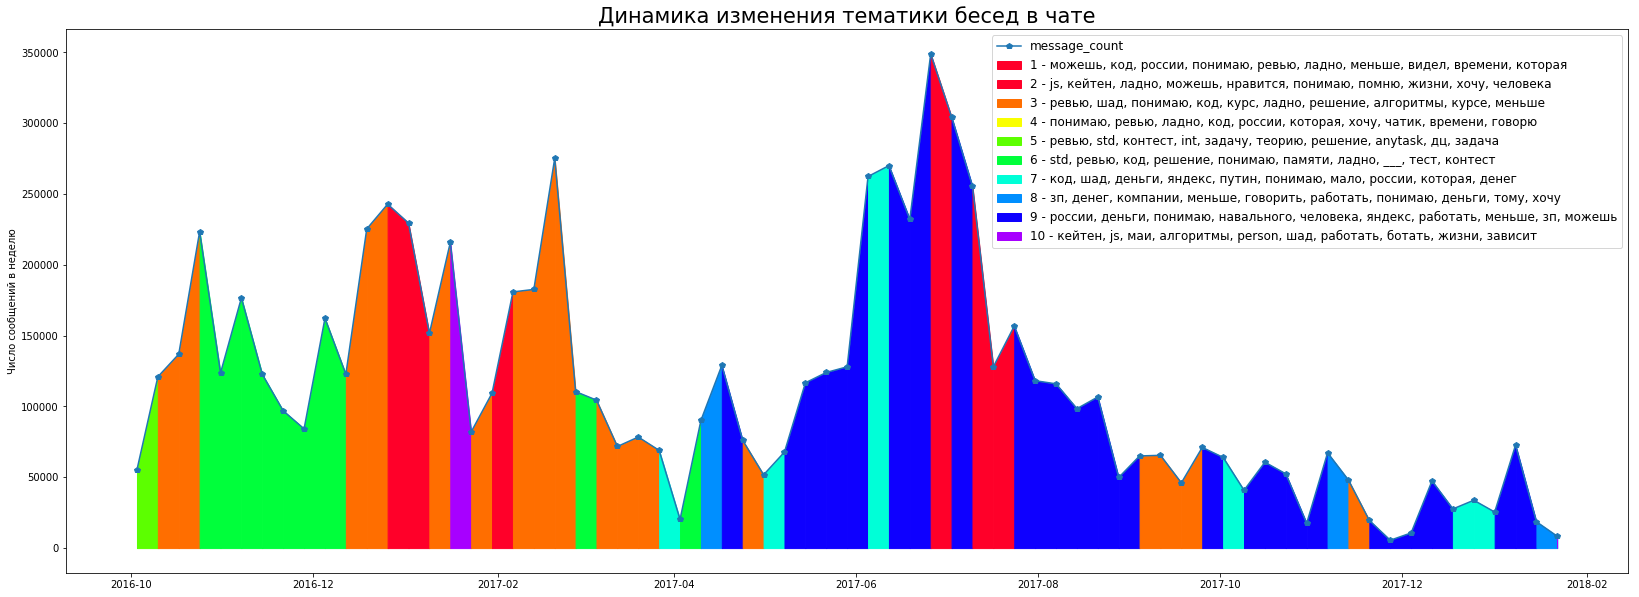

In [566]:
import matplotlib as mpl
cmap = mpl.cm.gist_rainbow
normalize = mpl.colors.Normalize(vmin=1, vmax=10)
cmap(normalize(3))

plt.figure(figsize=(28,10))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(10):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_week.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )
    
plt.legend(fontsize=12)
plt.ylabel('Число сообщений в неделю')
plt.title('Динамика изменения тематики бесед в чате', fontsize=21)
plt.savefig('topic_history.png')
plt.show()

### Та же модель с приведением к нормальной форме

In [567]:
morph = pymorphy2.MorphAnalyzer()
%time week_text_norm = week_text.apply(lambda x: normalise_string(x))
week_text_norm.head()

CPU times: user 3min 12s, sys: 280 ms, total: 3min 12s
Wall time: 3min 12s


mes_date
2016-40    пинить сообщение опубликать проверить непонятн...
2016-41    часы дедлайна теория ревить никакой движение п...
2016-42    гыы колоритный чувак нравиться видос делать на...
2016-43    видимо косяк мой решение слишком нетипичный за...
2016-44    человек ребятки давать подножать эм специальны...
Name: text, dtype: object

In [568]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(week_text_norm, min_df=0.05, max_df=0.95)

Слов в словаре: 16038

Слова до пороговой фильтрации:  [('человек', 6267), ('такой', 6058), ('весь', 5468), ('вообще', 5195), ('один', 4816), ('который', 4466), ('какой', 4087), ('мочь', 4072), ('знать', 3880), ('делать', 3859), ('год', 3802), ('говорить', 3511), ('писать', 3477), ('почему', 3345), ('самый', 3232), ('думать', 3169), ('хотеть', 3132), ('работать', 2999), ('тип', 2996), ('быть', 2962)] 

Слова у верхней границы: ['алгоритм', 'яндекс', 'россия', 'функция', 'тест', 'ревить', 'ребёнок', 'начать', 'страна', 'ладный', 'брать', 'идея', 'пойти', 'наш', 'кейтен', 'нравиться', 'куча', 'балл', 'гугл', 'девушка', 'шад', 'теория', 'сдать', 'класс', 'ходить', 'семестр', 'домашка', 'std', 'конец', 'алиса', 'школа', 'пример', 'контест', 'компания', 'лекция', 'егор', 'учиться', 'решать', 'остальной', 'плюс']

Слова у нижней границы:  ['революционер', 'otherwise', 'others', 'osx', 'жаждать', 'угловой', 'немаленький', 'бедняга', 'бедняжка', 'жа', 'нелепый', 'инфаркт', 'удалённость', 'open

In [572]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(week_text_norm, min_df=0.05, max_df=0.85)

Слов в словаре: 15768

Слова до пороговой фильтрации:  [('человек', 6267), ('такой', 6058), ('весь', 5468), ('вообще', 5195), ('один', 4816), ('который', 4466), ('какой', 4087), ('мочь', 4072), ('знать', 3880), ('делать', 3859), ('год', 3802), ('говорить', 3511), ('писать', 3477), ('почему', 3345), ('самый', 3232), ('думать', 3169), ('хотеть', 3132), ('работать', 2999), ('тип', 2996), ('быть', 2962)] 

Слова у верхней границы: ['кейтен', 'балл', 'std', 'алиса', 'контест', 'дедлайна', 'навальный', 'женщина', 'дерево', 'математика', 'js', 'путин', 'государство', 'команда', 'семинар', 'фильм', 'int', 'знание', 'играть', 'вика', 'интерфейс', 'оо', 'половина', 'закон', 'сша', 'ситуация', 'вектор', 'зп', 'зарплата', 'мехмат', 'общество', 'вести', 'образование', 'крутой', 'файл', 'книга', 'родитель', 'вуз', 'цена', 'зрение']

Слова у нижней границы:  ['купон', 'курский', 'устранение', 'правонарушение', 'кэшироваться', 'кюля', 'усыновить', 'лабаять', 'архимед', 'пра', 'арррить', 'поэтмоу', 'ут

In [570]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(week_text_norm, min_df=0.05, max_df=0.75)

Слов в словаре: 15461

Слова до пороговой фильтрации:  [('человек', 6267), ('такой', 6058), ('весь', 5468), ('вообще', 5195), ('один', 4816), ('который', 4466), ('какой', 4087), ('мочь', 4072), ('знать', 3880), ('делать', 3859), ('год', 3802), ('говорить', 3511), ('писать', 3477), ('почему', 3345), ('самый', 3232), ('думать', 3169), ('хотеть', 3132), ('работать', 2999), ('тип', 2996), ('быть', 2962)] 

Слова у верхней границы: ['кейтен', 'навальный', 'женщина', 'математика', 'js', 'путин', 'государство', 'семинар', 'int', 'вектор', 'зп', 'мехмат', 'родитель', 'парень', 'квартира', 'власть', 'наука', 'мужчина', 'предмет', 'менеджер', 'физтех', 'стайлгайда', 'массив', 'книжка', 'указатель', 'общаться', 'радомир', 'экономика', 'швейцария', 'вершина', 'структура', 'ссср', 'экзамен', 'ml', 'налог', 'вброса', 'математик', 'рынок', 'граф', 'война']

Слова у нижней границы:  ['даблин', 'вконтач', 'овальный', 'marked', 'уплыть', 'бач', 'перекидывать', 'преуспеть', 'покодить', 'овердофиг', 'техн

In [573]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(week_text_norm, min_df=0.05, max_df=0.65)

Слов в словаре: 15106

Слова до пороговой фильтрации:  [('человек', 6267), ('такой', 6058), ('весь', 5468), ('вообще', 5195), ('один', 4816), ('который', 4466), ('какой', 4087), ('мочь', 4072), ('знать', 3880), ('делать', 3859), ('год', 3802), ('говорить', 3511), ('писать', 3477), ('почему', 3345), ('самый', 3232), ('думать', 3169), ('хотеть', 3132), ('работать', 2999), ('тип', 2996), ('быть', 2962)] 

Слова у верхней границы: ['навальный', 'путин', 'зп', 'мехмат', 'наука', 'мужчина', 'стайлгайда', 'указатель', 'радомир', 'экономика', 'вершина', 'ссср', 'математик', 'рынок', 'const', 'доказательство', 'нму', 'стажер', 'собака', 'set', 'мгу', 'диплом', 'кафедра', 'метро', 'цюрих', 'жена', 'рф', 'мая', 'длина', 'китай', '___', 'физика', 'стресс', 'спойлер', 'виктор', 'фивт', 'санитайзер', 'сталин', 'доказывать', 'возвращать']

Слова у нижней границы:  ['закрепиться', 'прайс', 'прайма', 'трындец', 'трёшка', 'put', 'тс', 'туалетный', 'мотоциклист', 'правонарушение', 'времязатратный', 'пра'

In [579]:
lda_week_norm, gamma_week_norm = get_lda_model(counts, corpus_id2word)

ELBO = -3138182.1674, time: 105 seconds


In [580]:
build_topic_words_report(lda_week_norm, top_words_num=25)

0 topic: зп, док, грейд, сбер, мужчина, мораль, банка, сбербанк, гора, эверест, путин, навальный, сексизм, витя, поддержка, банк, указатель, фб, рынок, стайлгайда, метро, json, крупный, общага, феминизм
1 topic: персонаж, стейка, shit, зритель, монокль, холодильник, глава, уязвимость, сюжет, французский, риск, ядро, озарение, кино, развивать, казаться, способность, низкий, страховка, нок, рождение, немецкий, навык, auto, стереотип
2 topic: мехмат, наука, математик, кафедра, физика, мая, философия, нму, доказательство, анализ, радомир, фивт, мгу, алгебра, факультет, доказывать, теорема, пространство, программирование, бд, география, академ, учитель, интеграл, мфть
3 topic: мая, const, курить, семья, бросить, мужчина, ботать, person, французский, виктор, жена, сексизм, воспитание, немецкий, исследование, перл, мехмат, папа, концепция, сессия, кошка, прототип, банка, возвращать, ес
4 topic: навальный, си, мясо, корасик, стандарт, посадить, базовый, сериал, стейка, матрица, онлайн, диплом,

In [581]:
def weekpair_2date(pair):
    atime = time.strptime('{} {} 1'.format(*pair.split('-')), '%Y %W %w')
    return pd.to_datetime('{0}-{1}-{2}'.format(atime.tm_year, atime.tm_mon, atime.tm_mday))

topic_dynamic = pd.DataFrame(week_text_norm)
topic_dynamic['topic'] = np.argmax(gamma_week_norm, axis=1)
topic_dynamic['message_count'] = week_text.apply(len)
topic_dynamic['date'] = list(map(weekpair_2date, topic_dynamic.index))
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2016-40,пинить сообщение опубликать проверить непонятн...,9,55360,2016-10-03
2016-41,часы дедлайна теория ревить никакой движение п...,9,120953,2016-10-10
2016-42,гыы колоритный чувак нравиться видос делать на...,9,136913,2016-10-17
2016-43,видимо косяк мой решение слишком нетипичный за...,9,223447,2016-10-24
2016-44,человек ребятки давать подножать эм специальны...,9,123647,2016-10-31


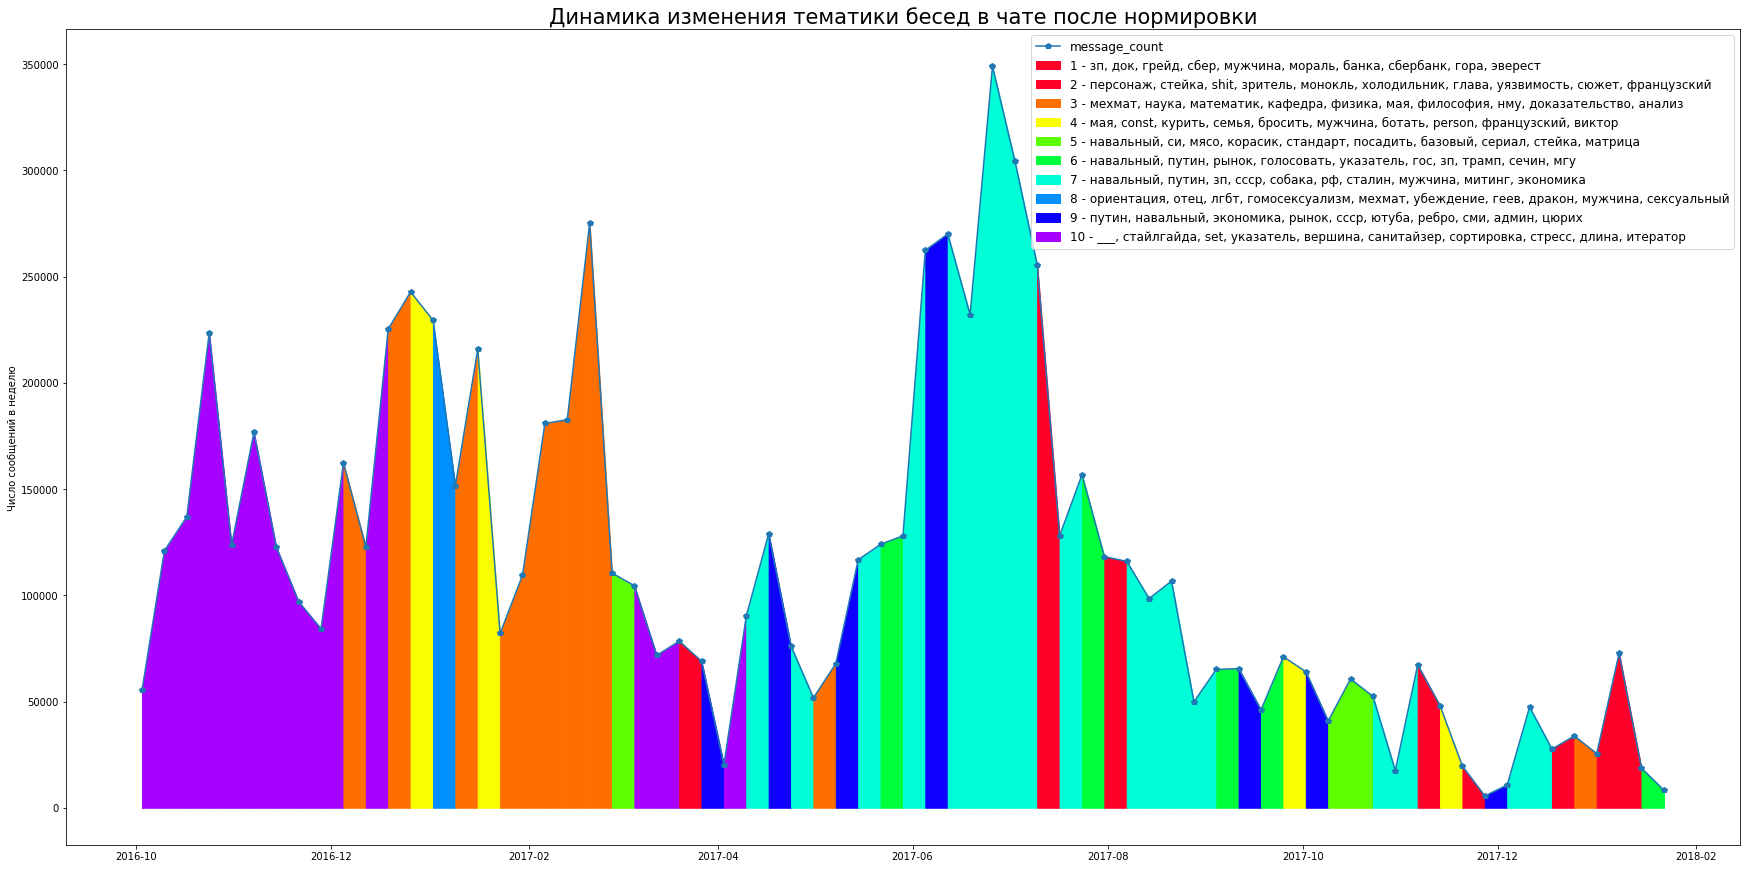

In [584]:
import matplotlib as mpl
cmap = mpl.cm.gist_rainbow
normalize = mpl.colors.Normalize(vmin=1, vmax=10)

plt.figure(figsize=(30,15))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(10):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_week_norm.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )
    
plt.legend(fontsize=12)
plt.ylabel('Число сообщений в неделю')
plt.title('Динамика изменения тематики бесед в чате после нормировки', fontsize=21)
plt.savefig('topic_history_norm.png')
plt.show()